**The City of San Francisco, like many cities, publishes crime data. This notebook shows basic exploratory data analysis as well as a couple of heat maps to help understand where and when crimes are committed in San Francisco.**

In [2]:
# import libraries

import pandas as pd
import folium as fl
import numpy as np
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

In [5]:
# import data

dfCrime = pd.read_csv(path)

dfCrime.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,120058272,WEAPON LAWS,POSS OF PROHIBITED WEAPON,Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212120
1,120058272,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212168
2,141059263,WARRANTS,WARRANT ARREST,Monday,04/25/2016 12:00:00 AM,14:59,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)",14105926363010
3,160013662,NON-CRIMINAL,LOST PROPERTY,Tuesday,01/05/2016 12:00:00 AM,23:50,TENDERLOIN,NONE,JONES ST / OFARRELL ST,-122.412971,37.785788,"(37.7857883766888, -122.412970537591)",16001366271000
4,160002740,NON-CRIMINAL,LOST PROPERTY,Friday,01/01/2016 12:00:00 AM,00:30,MISSION,NONE,16TH ST / MISSION ST,-122.419672,37.765050,"(37.7650501214668, -122.419671780296)",16000274071000


In [6]:
dfCrime.describe()

,IncidntNum,X,Y,PdId
count,1.505000e+05,150500.000000,150500.000000,1.505000e+05
mean,1.616440e+08,-122.423599,37.768921,1.616440e+13
std,5.535976e+06,0.026210,0.023637,5.535976e+11
min,1.135121e+07,-122.513642,37.707922,1.135121e+12
25%,1.603283e+08,-122.434036,37.756486,1.603283e+13
50%,1.606541e+08,-122.416903,37.775421,1.606541e+13
75%,1.609764e+08,-122.406605,37.785063,1.609764e+13
max,9.910090e+08,-122.365565,37.819975,9.910090e+13


In [7]:
dfCrime.dtypes

IncidntNum      int64
Category       object
Descript       object
DayOfWeek      object
Date           object
Time           object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
Location       object
PdId            int64
dtype: object

I'd like to add a couple of datetime columns to the dataframe to 1) practice doing that kind of work and 2) help in sorting the data by when it occurred.

In [8]:
dfCrime.Date = pd.to_datetime(dfCrime.Date,format = "%m/%d/%Y %H:%M:%S %p")
dfCrime["Month"] = dfCrime.Date.apply(lambda x: x.month)
dfCrime["DayOfMonth"] = dfCrime.Date.apply(lambda x: x.day)
dfCrime.sort_values(["Month","DayOfMonth","Time"],inplace=True)
dfCrime.reset_index(drop=True,inplace=True)
dfCrime.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,Month,DayOfMonth
0,160040847,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Friday,2016-01-01 12:00:00,00:01,INGLESIDE,NONE,800 Block of ROLPH ST,-122.428641,37.711189,"(37.7111887011083, -122.428641379657)",16004084764070,1,1
1,160049708,NON-CRIMINAL,LOST PROPERTY,Friday,2016-01-01 12:00:00,00:01,NORTHERN,NONE,1300 Block of VANNESS AV,-122.421734,37.788296,"(37.7882961275539, -122.421734189838)",16004970871000,1,1
2,151123444,FORGERY/COUNTERFEITING,"FINANCIAL STATEMENTS, FALSE",Friday,2016-01-01 12:00:00,00:01,CENTRAL,UNFOUNDED,600 Block of GEARY ST,-122.414011,37.786677,"(37.7866770011071, -122.414010814727)",15112344409167,1,1
3,151123444,NON-CRIMINAL,CASE CLOSURE,Friday,2016-01-01 12:00:00,00:01,CENTRAL,UNFOUNDED,600 Block of GEARY ST,-122.414011,37.786677,"(37.7866770011071, -122.414010814727)",15112344475030,1,1
4,160193195,ASSAULT,BATTERY,Friday,2016-01-01 12:00:00,00:01,NORTHERN,NONE,1000 Block of POLK ST,-122.419858,37.786137,"(37.786137125238, -122.419858277339)",16019319504134,1,1


Now I want to do some visualizations to better understand the data. I'll start by looking at the day of the week and month crimes are committed to see if certain days/months are generally more crime-ridden.

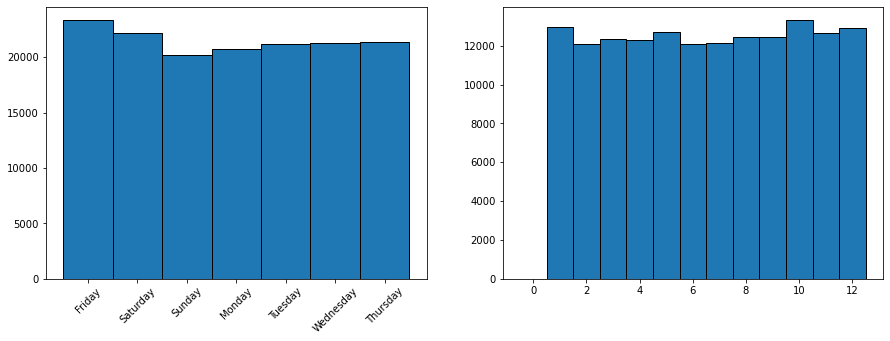

In [10]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

axes[0].hist(dfCrime["DayOfWeek"],bins=np.arange(8)-.5,edgecolor="black")
axes[0].tick_params("x",labelrotation=45)
axes[1].hist(dfCrime["Month"],bins=np.arange(14)-.5,edgecolor="black")
plt.show()

Well, not all charts can be enlightening. It seems like Friday and Saturday have the highest crime totals - likely due to more people being out on the streets. Other than that, it's hard to see any kind of trend so far. Let's limit the dataset to only violent crimes. First step is to see all the unique crime types from the set and build a list of violent crimes.

In [11]:
crimes = list(dfAll["Category"].unique())
crimes

['WEAPON LAWS',
 'WARRANTS',
 'NON-CRIMINAL',
 'ASSAULT',
 'OTHER OFFENSES',
 'MISSING PERSON',
 'LARCENY/THEFT',
 'BURGLARY',
 'STOLEN PROPERTY',
 'ROBBERY',
 'FRAUD',
 'DRUG/NARCOTIC',
 'VEHICLE THEFT',
 'RECOVERED VEHICLE',
 'VANDALISM',
 'ARSON',
 'PROSTITUTION',
 'SECONDARY CODES',
 'SUSPICIOUS OCC',
 'DRUNKENNESS',
 'TRESPASS',
 'SEX OFFENSES, NON FORCIBLE',
 'SEX OFFENSES, FORCIBLE',
 'RUNAWAY',
 'KIDNAPPING',
 'DISORDERLY CONDUCT',
 'DRIVING UNDER THE INFLUENCE',
 'FORGERY/COUNTERFEITING',
 'EMBEZZLEMENT',
 'BRIBERY',
 'FAMILY OFFENSES',
 'GAMBLING',
 'SUICIDE',
 'LIQUOR LAWS',
 'EXTORTION',
 'LOITERING',
 'TREA',
 'BAD CHECKS',
 'PORNOGRAPHY/OBSCENE MAT']

In [12]:
violent = ["ASSAULT","KIDNAPPING","SEX OFFENSES, FORCIBLE","ROBBERY","ARSON","SUICIDE"]

dfViolent = dfCrime[dfCrime["Category"].isin(violent)]
dfViolent.reset_index(drop=True,inplace=True)
dfViolent.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,Month,DayOfMonth
0,160193195,ASSAULT,BATTERY,Friday,2016-01-01 12:00:00,00:01,NORTHERN,NONE,1000 Block of POLK ST,-122.419858,37.786137,"(37.786137125238, -122.419858277339)",16019319504134,1,1
1,160008936,ASSAULT,BATTERY,Friday,2016-01-01 12:00:00,00:01,CENTRAL,NONE,300 Block of POWELL ST,-122.408384,37.787827,"(37.7878271137225, -122.408384275542)",16000893604134,1,1
2,160456329,"SEX OFFENSES, FORCIBLE","CHILD ABUSE, PORNOGRAPHY",Friday,2016-01-01 12:00:00,00:01,TARAVAL,NONE,2500 Block of 43RD AV,-122.501137,37.739106,"(37.7391055984262, -122.501136734572)",16045632915017,1,1
3,160999341,"SEX OFFENSES, FORCIBLE","SEXUAL ASSAULT, AGGRAVATED, OF CHILD",Friday,2016-01-01 12:00:00,00:01,INGLESIDE,NONE,0 Block of SGTJOHNVYOUNG LN,-122.444707,37.724931,"(37.7249307267936, -122.444707063455)",16099934104147,1,1
4,160000136,ASSAULT,INFLICT INJURY ON COHABITEE,Friday,2016-01-01 12:00:00,00:01,NORTHERN,NONE,0 Block of POLK ST,-122.417998,37.776955,"(37.7769551138436, -122.41799760821)",16000013615040,1,1


In [13]:
dfViolent.describe()

,IncidntNum,X,Y,PdId,Month,DayOfMonth
count,1.842800e+04,18428.000000,18428.000000,1.842800e+04,18428.000000,18428.000000
mean,1.606215e+08,-122.420535,37.764548,1.606215e+13,6.564196,15.762427
std,1.473284e+06,0.024247,0.025372,1.473284e+11,3.460113,8.798838
min,1.004753e+08,-122.513642,37.708311,1.004753e+13,1.000000,1.000000
25%,1.602818e+08,-122.429134,37.745914,1.602818e+13,4.000000,8.000000
50%,1.605509e+08,-122.415740,37.772473,1.605509e+13,7.000000,16.000000
75%,1.608184e+08,-122.406539,37.783994,1.608184e+13,10.000000,23.000000
max,1.790023e+08,-122.365565,37.819975,1.790023e+13,12.000000,31.000000


Wow, 18,000+ violent crimes in one city in one year. The world is a dangerous place. Imagine planning a visit to San Francisco and looking at this data. It might be nice to know where this kind of crime happens around the city so, as a visitor, you could potentially avoid those areas. I'll create a heatmap of these violent crimes here.

In [14]:
sfcrimemap = fl.Map(location = [37.7739,-122.4312],tiles="Stamen Toner",zoom_start=12) # create the basemap

HeatMap(dfViolent[["Y","X"]].groupby(["Y","X"]).sum().reset_index().values.tolist(),radius=12,max_zoom=5).add_to(sfcrimemap)

title_html = '''
             <h3 align="center" style="font-size:20px"><b>Violent Crime in SF</b></h3>
             '''
sfcrimemap.get_root().html.add_child(fl.Element(title_html))

sfcrimemap

This is a solid map. Not surprisingly, violent crimes seem to be concentrated in the downtown area of SF. This is where people and crowds are most dense so it makes sense there would be more crime here. Something important to remember, however, is that this is a dataset and map of reported crime. It's entirely possible a lot of crime goes unreported in other parts of the city for a variety of reasons. This doesn't mean any one part (or the city as a whole) is dangerous, simply a comment on how individuals and communities often handle crime.

I'd also like to take a look at drug-related crime in the city. Drug abuse in SF is highly publicized - I'm curious about where and when those crimes take place.

In [17]:
dfDrugs = dfCrime[dfCrime["Category"] == "DRUG/NARCOTIC"]
dfDrugs.reset_index(drop=True,inplace=True)
dfDrugs.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,Month,DayOfMonth
0,160002154,DRUG/NARCOTIC,POSSESSION OF METH-AMPHETAMINE,Friday,2016-01-01 12:00:00,00:01,MISSION,"ARREST, BOOKED",16TH ST / HARRISON ST,-122.413108,37.765448,"(37.7654480180266, -122.413107622693)",16000215416650,1,1
1,160000283,DRUG/NARCOTIC,POSSESSION OF CONTROLLED SUBSTANCE,Friday,2016-01-01 12:00:00,00:07,NORTHERN,"ARREST, BOOKED",POLK ST / CEDAR ST,-122.419835,37.786358,"(37.7863580362743, -122.419834938618)",16000028316660,1,1
2,130749546,DRUG/NARCOTIC,POSSESSION OF MARIJUANA,Friday,2016-01-01 12:00:00,08:37,TENDERLOIN,"ARREST, BOOKED",EDDY ST / TAYLOR ST,-122.410955,37.784140,"(37.7841399509594, -122.410955248906)",13074954616010,1,1
3,130749546,DRUG/NARCOTIC,POSSESSION OF BASE/ROCK COCAINE FOR SALE,Friday,2016-01-01 12:00:00,08:37,TENDERLOIN,"ARREST, BOOKED",EDDY ST / TAYLOR ST,-122.410955,37.784140,"(37.7841399509594, -122.410955248906)",13074954616623,1,1
4,160001253,DRUG/NARCOTIC,POSSESSION OF MARIJUANA FOR SALES,Friday,2016-01-01 12:00:00,10:56,SOUTHERN,"ARREST, BOOKED",1000 Block of MARKET ST,-122.411071,37.781751,"(37.7817511307229, -122.411071423064)",16000125316030,1,1


In [18]:
dfDrugs.describe()

,IncidntNum,X,Y,PdId,Month,DayOfMonth
count,4.243000e+03,4243.000000,4243.000000,4.243000e+03,4243.000000,4243.000000
mean,1.605239e+08,-122.418538,37.771479,1.605239e+13,6.285411,15.227669
std,1.260555e+06,0.018595,0.018883,1.260555e+11,3.443809,8.834938
min,1.203506e+08,-122.510525,37.708311,1.203506e+13,1.000000,1.000000
25%,1.602510e+08,-122.420642,37.765110,1.602510e+13,3.000000,7.000000
50%,1.604907e+08,-122.415349,37.779648,1.604907e+13,6.000000,15.000000
75%,1.607926e+08,-122.409504,37.782793,1.607926e+13,9.000000,23.000000
max,1.701782e+08,-122.373376,37.808625,1.701782e+13,12.000000,31.000000


As compared to violent crimes, drug offenses seem to be much less common. I'd like to know which types are most common so I'll group by the "Descript" column.

In [30]:
dfDrugsGrouped = dfDrugs.groupby("Descript").count()
dfDrugsGrouped = dfDrugsGrouped[["Month"]]
dfDrugsGrouped.rename(columns={"Month":"Count"},inplace=True)
dfDrugsGrouped.sort_values("Count",ascending=False)

,Count
Descript,
POSSESSION OF NARCOTICS PARAPHERNALIA,1065
POSSESSION OF METH-AMPHETAMINE,562
POSSESSION OF MARIJUANA,431
POSSESSION OF METH-AMPHETAMINE FOR SALE,248
POSSESSION OF BASE/ROCK COCAINE FOR SALE,245
POSSESSION OF HEROIN,189
POSSESSION OF MARIJUANA FOR SALES,184
POSSESSION OF HEROIN FOR SALES,173
SALE OF BASE/ROCK COCAINE,140


Fairly predictable that "Paraphernalia" is the most common offense, but it's surprising to see possesion of hard drugs like meth, cocaine, and heroin rank so highly - meth is even above marijuana! From here, I'll build another heat map of these crimes. I have a suspicion it will look similar to the violent crime map, but let's find out.

In [32]:
sfdrugmap = fl.Map(location = [37.7739,-122.4312],tiles="Stamen Toner",zoom_start=12) # create the basemap

HeatMap(dfDrugs[["Y","X"]].groupby(["Y","X"]).sum().reset_index().values.tolist(),radius=12,max_zoom=5).add_to(sfdrugmap)

title_html = '''
             <h3 align="center" style="font-size:20px"><b>Drug-Related Crime in SF</b></h3>
             '''
sfdrugmap.get_root().html.add_child(fl.Element(title_html))

sfdrugmap

Ok so there are some slight differences in hotspots for drug vs violent crime in San Francisco. That said, the hottest area for drug crime is almost identical to the area for violent crime. Once again, this area seems to be the downtown area - where people are. 

There are three basic reasons the volume of reported crimes in these two categories is relatively high in this area:
1. There are simply more people here. More people means more crimes.
2. When there are more people in an area, there is typcially a stronger police presence.
3. With more people and more police officers around, the odds of a given crime being spotted and reported jump significantly.

As a non-resident of SF, I cannont possibly know all the reasons these areas are more likely to have certain types of crimes than others. This is an attempt to explain the hotspots with basic logic and knowledge from experience with humans in general.

**This data comes directly from the City of San Francisco and is from 2016. I feel, based on this information, I have a better understanding of crime in a city that is often in the news. For expanding this project, it might be interesting to repeat the steps for newer data and see how crime has changed over the last five years. Such a study would provide good information on how the city's efforts to reduce crime are working in different areas and will different types of crime.**